In [1]:
import pandas as pd
import random
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import math

In [2]:
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:


class USBattleship(gym.Env):
    def __init__(self):
        # Define observation and action spaces
        self.observation_space = gym.spaces.Discrete(25)  # 5x5 grid
        self.action_space = gym.spaces.Discrete(25)  # 5x5 grid actions

    def _action_to_coordinates(self, action):
        """Converts action (0-24) into grid coordinates (x, y)."""
        return divmod(action, 5)  # Returns (row, column)

    def step(self, action, battleship_grid, hit, done, hit_count):
        assert self.action_space.contains(action), "Invalid action!"

        x, y = self._action_to_coordinates(action)

        if done:
            return -1, hit, action, done, battleship_grid, hit_count, {"message": "Game is already finished."}

        if battleship_grid[x, y] == 1:  # Hit condition
            hit_count += 1
            battleship_grid[x, y] = 0
            reward = 1
            hit = True
            if hit_count == 2:  # Game ends after 2 hits
                done = True
        else:  # Miss condition
            battleship_grid[x, y] = 2  # Mark as visited
            reward = -1
            hit = False

        return reward, hit, action, done, battleship_grid, hit_count, {}

    def _initialize_board(self):
        """Initializes a 5x5 game board."""
        return np.zeros((5, 5), dtype=int)

    def _random_orientation(self):
        """Randomly chooses between horizontal (0) and vertical (1)."""
        return np.random.choice([0, 1])

    def _place_ship(self):
        """Places a 2-cell ship on the board."""
        board = self._initialize_board()
        orientation = self._random_orientation()

        if orientation == 0:  # Horizontal placement
            x = np.random.randint(0, 5)
            y = np.random.randint(0, 4)  # Ensure space for 2-cell ship
            board[x, y:y+2] = 1
        else:  # Vertical placement
            x = np.random.randint(0, 4)  # Ensure space for 2-cell ship
            y = np.random.randint(0, 5)
            board[x:x+2, y] = 1

        return board

    def reset(self):
        """Resets the game state."""
        battleship_grid = self._place_ship()
        return battleship_grid


In [4]:


# Initialize the environment
env = USBattleship()

# Parameters
num_episodes = 10000
max_steps_per_episode = 16

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

# State and action space size
state_space_size = env.observation_space.n
action_space_size = env.action_space.n

# Initialize Q-table
q_table = np.zeros((state_space_size, action_space_size))

holdermeanx = []
plot_meanx = []
plot_stepmeanx = []
holdermeanstepx = []

for x in range(10):
    np.random.seed(0)
    rewards_all_episodes = []
    ep_count = []
    tm = []
    graph_step = []
    graph_ep = []
    reward_pre = []
    meanstep = []

    # Q-Learning algorithm
    for episode in range(num_episodes):
        possible_actions = list(range(action_space_size))

        # Reset environment
        ship = env.reset()
        hit = False
        done = False
        hit_count = 0

        rewards_current_episode = 0
        state = None

        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_rate_threshold = random.uniform(0, 1)
            if exploration_rate_threshold > exploration_rate:
                if state is not None:
                    action = np.argmax(q_table[state, :])
                else:
                    action = random.choice(possible_actions)
            else:
                action = random.choice(possible_actions)

            # Remove action from possible actions
            if action in possible_actions:
                possible_actions.remove(action)

            # Execute action
            reward, hit, new_state, done, ship, hit_count, info = env.step(action, ship, hit, done, hit_count)

            # Update Q-table
            if state is not None:
                q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
                    learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))

            state = new_state
            rewards_current_episode += reward

            if done:
                break

        graph_step.append(step)
        graph_ep.append(episode)
        reward_pre.append(rewards_current_episode)

        # Exploration rate decay
        exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

        rewards_all_episodes.append(rewards_current_episode)

    # Calculate statistics
    rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)

    count = 0
    for r in rewards_per_thousand_episodes:
        tm1 = np.mean(rewards_all_episodes[count:count+100])
        meanstep1 = np.mean(graph_step[count:count+100])

        ep_count.append(count + 100)
        tm.append(tm1)
        holdermeanx.append(tm1)
        meanstep.append(meanstep1)
        holdermeanstepx.append(meanstep1)
        count += 100




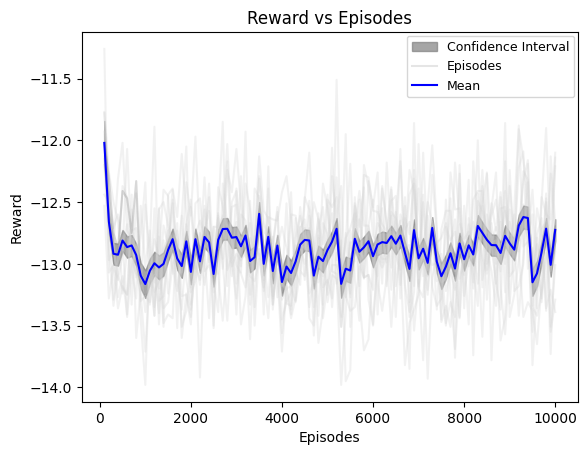

In [7]:


# Compute the mean scores for plot_meanx and plot_stepmeanx
plot_meanx = []
plot_stepmeanx = []

for r in range(100):
    meanxscore2 = np.mean([holdermeanx[r + i * 100] for i in range(10)])
    plot_meanx.append(meanxscore2)

    meanstepx = np.mean([holdermeanstepx[r + i * 100] for i in range(10)])
    plot_stepmeanx.append(meanstepx)

# Calculate the confidence interval
sumlist = []
for t in range(100):
    std_dev = math.sqrt(np.mean([(holdermeanx[n] - plot_meanx[t])**2 for n in range(0, 1000, 10)]))
    sumlist.append(std_dev)

sumlist = np.array(sumlist)
confidence_upper = np.array(plot_meanx) + 2 * sumlist / math.sqrt(100)
confidence_lower = np.array(plot_meanx) - 2 * sumlist / math.sqrt(100)

# Plot the confidence interval
plt.fill_between(
    ep_count, confidence_upper, confidence_lower, color='gray', alpha=0.7, label="Confidence Interval"
)

# Plot individual episode traces
for start in range(0, 1000, 100):
    plt.plot(ep_count, holdermeanx[start:start + 100], color='lightgray', alpha=0.3)

# Plot the first 10 episodes trace
plt.plot(ep_count[:10], holdermeanx[:10], color='black', alpha=0.1, label="Episodes")

# Plot the mean
plt.plot(ep_count, plot_meanx, label="Mean", color='blue')

# Label and title
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episodes')
plt.legend(loc='upper right', fontsize="9", borderaxespad=0.3)

# Show the plot
plt.show()

able to see that our Qtable beats randomly guessing


Negative Hypergeometric Distribution says:
    \begin{equation*}
        \mu = \frac{rK}{N-K+1}
    \end{equation*}

Using N = 25, K = miss = 23, and R = hits = 2. We expect our ship to get sank in around 15.5 turns on average

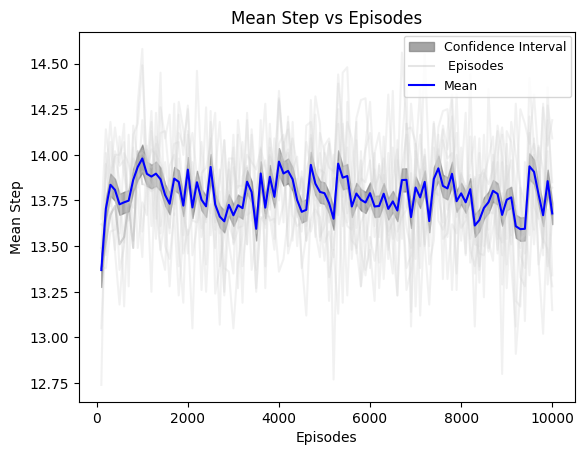

In [8]:
# Calculate the confidence intervals for plot_stepmeanx
sumlist = []

for t in range(100):
    std_dev = math.sqrt(
        np.mean([(holdermeanstepx[n] - plot_stepmeanx[t]) ** 2 for n in range(0, 1000, 10)])
    )
    sumlist.append(std_dev)

sumlist = np.array(sumlist)
confidence_upper = np.array(plot_stepmeanx) + 2 * sumlist / math.sqrt(100)
confidence_lower = np.array(plot_stepmeanx) - 2 * sumlist / math.sqrt(100)

# Plot the confidence interval
plt.fill_between(
    ep_count, confidence_upper, confidence_lower, color='gray', alpha=0.7, label="Confidence Interval"
)

# Plot individual episode traces
for start in range(0, 1000, 100):
    plt.plot(ep_count, holdermeanstepx[start:start + 100], color='lightgray', alpha=0.3)

# Plot the first 10 episodes trace
plt.plot(ep_count[:10], holdermeanstepx[:10], color='black', alpha=0.1, label=" Episodes")

# Plot the mean
plt.plot(ep_count, plot_stepmeanx, label="Mean", color='blue')

# Add labels, legend, and title
plt.xlabel('Episodes')
plt.ylabel('Mean Step')
plt.title('Mean Step vs Episodes')
plt.legend(loc='upper right', fontsize="9", borderaxespad=0.3)

# Show the plot
plt.show()